## Building the graph

### Clipping: All except colabs mentioning "python" + Colabs mentioning only "Javascript"

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [57]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [58]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [59]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [60]:
#All except colabs mentioning "python" + Colabs mentioning only "Javascript"
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'python' in str(x).lower())]
data = data[data['BODY'].notna() & data['BODY'].str.lower().str.contains('javascript',case=False)]


In [61]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [62]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
417,codeschool-kiddo,2015-01-01T11:14:16Z,Looks good! Could you also please mention your...,deadlyvipers
489,codeschool-kiddo,2015-01-01T11:56:02Z,Looks good! Could you also please mention your...,deadlyvipers
589,codeschool-kiddo,2015-01-01T13:00:13Z,Looks good! Could you also please mention your...,deadlyvipers
749,domelaz,2015-01-01T14:01:16Z,И список заказов надо вынести нафиг из `orders...,robespier
...,...,...,...,...
634241,codeschool-kiddo,2015-02-28T03:11:38Z,Looks good! Could you also please mention your...,deadlyvipers
634266,codeschool-kiddo,2015-02-28T03:18:47Z,Looks good! Could you also please mention your...,deadlyvipers
634698,daveross,2015-02-28T05:54:45Z,This file is generated from CoffeeScript. The ...,AaronHolbrook
635126,rexxarM,2015-02-28T08:48:18Z,@kennytm does iOS support this way to invoke ...,hihex


In [63]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
codeschool-kiddo    768
stvstnfrd            39
jirikuncar           34
vladberteanu         33
Cheerazar            31
                   ... 
ehoogerbeets          1
edwlook               1
eddiemonge            1
ecordell              1
zxqfox                1
Name: source, Length: 1499, dtype: int64

In [64]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    1499.000000
mean        2.154103
std        19.920091
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       768.000000
Name: source, dtype: float64

In [65]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['deadlyvipers', 'edx', 'Stanford-Online', 'iojs', 'TuxedoJS',
       'jirikuncar', 'mozilla', 'code-dot-org', 'ramda', 'mozilla-b2g',
       ...
       'bbfsdev', 'pablofantini', 'eriksilver', 'to-sho-kan', 'raszi', 'babel',
       'mightyLake', 'fibric', 'am11', 'LaunchAcademy'],
      dtype='object', name='source', length=193)

In [66]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [67]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
417,codeschool-kiddo,2015-01-01T11:14:16Z,Looks good! Could you also please mention your...,deadlyvipers
489,codeschool-kiddo,2015-01-01T11:56:02Z,Looks good! Could you also please mention your...,deadlyvipers
589,codeschool-kiddo,2015-01-01T13:00:13Z,Looks good! Could you also please mention your...,deadlyvipers
876,codeschool-kiddo,2015-01-01T14:34:33Z,Looks good! Could you also please mention your...,deadlyvipers
...,...,...,...,...
633511,codeschool-kiddo,2015-02-28T21:28:50Z,Looks good! Could you also please mention your...,deadlyvipers
633789,CrossEye,2015-02-28T22:22:33Z,>> I want my Maybe to be as bullet-proof as p...,plaid
633940,codeschool-kiddo,2015-02-28T23:01:58Z,Looks good! Could you also please mention your...,deadlyvipers
634241,codeschool-kiddo,2015-02-28T03:11:38Z,Looks good! Could you also please mention your...,deadlyvipers


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [68]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [69]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
yosuke-furukawa     0.000326
aik099              0.000434
radavis             0.000434
harrychenca         0.000434
fredj               0.000651
                      ...   
Cheerazar           0.040365
jirikuncar          0.041705
vladberteanu        0.042969
stvstnfrd           0.050781
codeschool-kiddo    1.000000
Name: source, Length: 551, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [70]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
6svalbard9                                                     [chilipote]
6to5                     [RReverser, chicoxyzzy, jridgewell, sebmck, st...
AdamYee                                                          [AdamYee]
AnalyticalGraphicsInc                          [bagnell, pjcozzi, shunter]
Animatron                                                      [shamansir]
                                               ...                        
vikram-s-narayan                                            [vladberteanu]
wcandillon                                [borisirota, ruhley, wcandillon]
wikimedia                                                [d00rman, gwicke]
wirsingio                       [DominikGuzei, clemenshelm, pferdefleisch]
zotero                                     [aurimasv, dstillman, fbennett]
Name: AUTHOR, Length: 193, dtype: object

In [71]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [72]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 511


#### Number of edges in the graph

In [73]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 1304


#### Density of the graph

In [74]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

130305

In [75]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.010007290587467865


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [76]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [77]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
RReverser,0.000651,1
chicoxyzzy,0.001302,1
jridgewell,0.001042,2
sebmck,0.015718,13
stebru,0.001302,1


##### Adding clustering and degree metrics

In [78]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,511.000000,511.000000,511.000000,511.000000
mean,0.004725,3.681018,0.763328,0.010007
std,0.044275,34.004296,0.420042,0.010048
min,0.000326,1.000000,0.000000,0.001961
25%,0.001302,1.000000,0.881423,0.003922
50%,0.001302,1.000000,1.000000,0.005882
75%,0.002604,2.000000,1.000000,0.011765
max,1.000000,768.000000,1.000000,0.045098


In [79]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,511.000000
mean,5.103718
std,5.124241
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,23.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

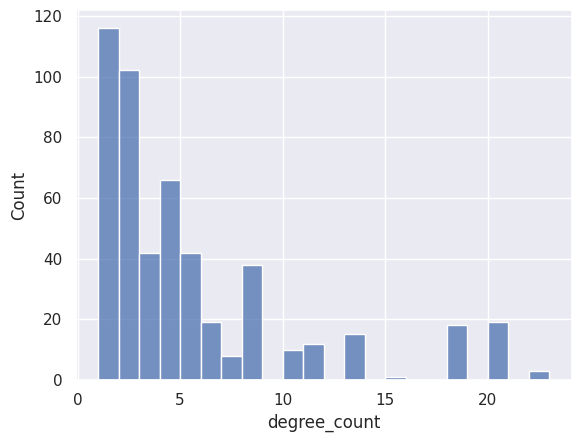

In [80]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [81]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [82]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [83]:
data['degree'].describe().to_frame()

,degree
count,510.000000
mean,0.009985
std,0.010044
min,0.001961
25%,0.003922
50%,0.005882
75%,0.011765
max,0.045098


In [84]:
data['focus'].describe().to_frame()

,focus
count,5.100000e+02
mean,4.852290e-02
std,7.464723e-02
min,1.000000e-10
25%,1.935484e-02
50%,1.935484e-02
75%,4.516129e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

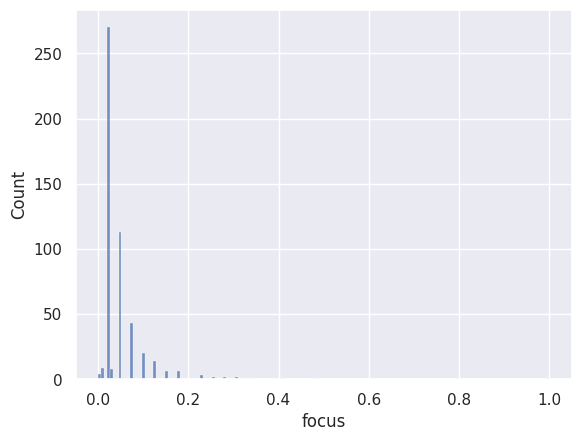

In [85]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

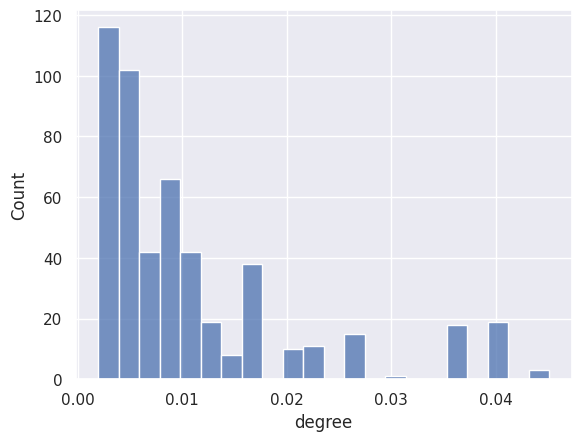

In [86]:
sns.histplot(data['degree'])

In [87]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

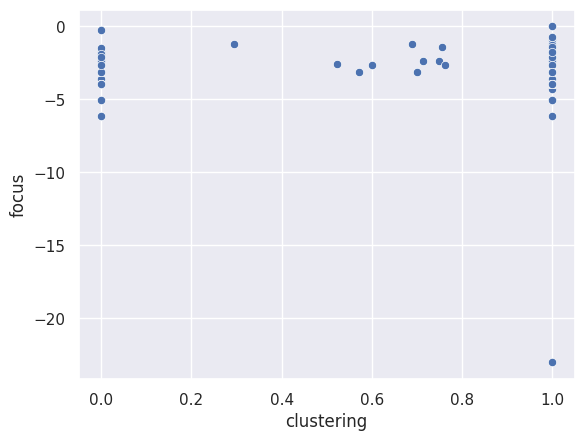

In [88]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [89]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
stvstnfrd,1.000000e+00,39,1.0,0.007843,4
Cheerazar,7.935484e-01,31,0.0,0.001961,1
houndci,4.883590e-01,21,1.0,0.005882,3
islemaster,4.064516e-01,16,1.0,0.011765,6
jagtalon,3.290323e-01,13,1.0,0.007843,4
...,...,...,...,...,...
RReverser,6.451613e-03,1,1.0,0.009804,5
radavis,2.150538e-03,1,0.0,0.001961,1
harrychenca,2.150538e-03,1,0.0,0.001961,1


### Residuals

In [90]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [91]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.536
Date:                Thu, 08 Jun 2023   Prob (F-statistic):              0.216
Time:                        18:31:04   Log-Likelihood:                 601.05
No. Observations:                 510   AIC:                            -1198.
Df Residuals:                     508   BIC:                            -1190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0560      0.007      8.168      0.000       0.043       0.069
clustering    -0.0098      0.008     -1.240      0.216      -0.025       0.006
==============================================================================
Omnibus:                      713.307   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121087.044
Skew:                           7.287   Prob(JB):                         0.00
Kurtosis:                      77.066   Cond. No.                         3.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.009752,0.007868,0.215717


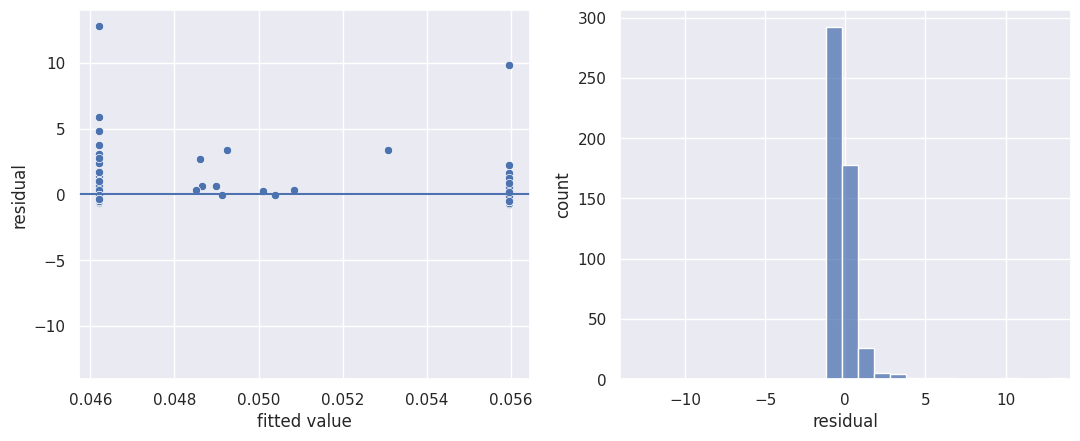

In [93]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [94]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [95]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.845
Date:                Thu, 08 Jun 2023   Prob (F-statistic):             0.0590
Time:                        18:31:05   Log-Likelihood:                -801.82
No. Observations:                 510   AIC:                             1610.
Df Residuals:                     507   BIC:                             1622.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2407      0.108    -29.932      0.000      -3.453      -3.028
clustering    -0.2498      0.135     -1.847      0.065      -0.516       0.016
degree        -3.4862      5.661     -0.616      0.538     -14.608       7.635
==============================================================================
Omnibus:                      810.789   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           475128.794
Skew:                          -8.744   Prob(JB):                         0.00
Kurtosis:                     151.503   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.249833,0.135276,0.065353
degree,-3.486249,5.660895,0.538271


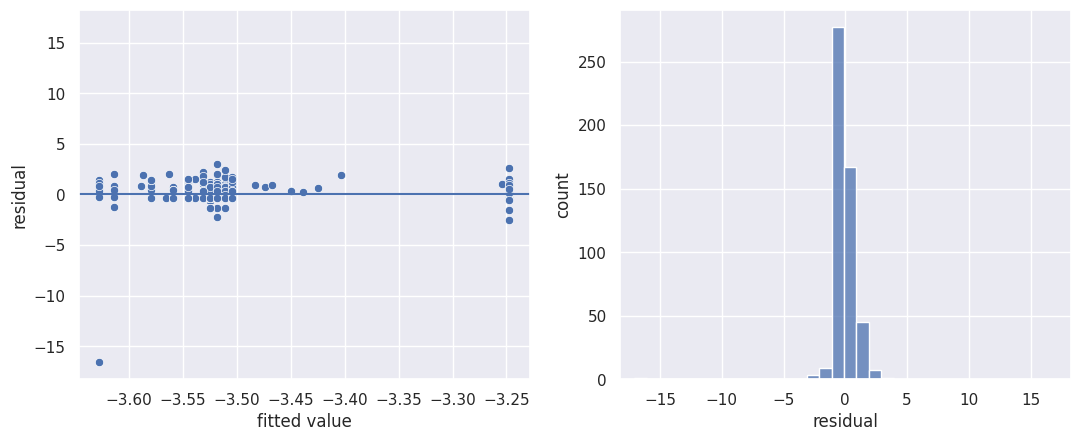

In [97]:
result.plot_residuals()

## Saving the graph

In [98]:
import netpixi

In [99]:
gt_save(g, '../networks/colabs_except_python_only_js.net.gz')